#  I  made some modifications for this sample

# Import packages

In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For Plotting
import matplotlib.pyplot as plt

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(3407)

# Args

In [2]:
class Args:
    def __init__(self) -> None:

        '''***********- model params -*************'''
        self.model_name = "hw1"

        '''***********- data path -*************'''
        self.data_path = '../../../data/hw1/'
        self.train_file='covid.train.csv'
        self.val_file = ''
        self.test_file = 'covid.test.csv'
        self.submit_file = '../../../submit/{}.csv'.format(self.model_name)

        '''***********- model path -*************'''
        self.MODEL_PATH = '../../../ckpts/{}'.format(self.model_name)
        if not os.path.exists(self.MODEL_PATH):
            os.makedirs(self.MODEL_PATH)

        '''***********- cpu or gpu and dara parallel -*************'''
        # self.gpus = [] # cpu
        # self.gpus = [0] # single gpu
        self.gpus = [0] # multi gpu
        self.WORKERS = 5 # num of workers for data loader

        '''***********- Hyper Arguments -*************'''
        self.rand_seed=40
        self.batch_size = 256
        self.lr = 1e-3
        self.epochs = 200
        self.split_ratio = 0.2
        self.patience = 20
        self.l2_lambda = 0.1

# Utils

In [3]:
def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Model

In [5]:
# baseline
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        x = self.net(x)
        x = x.squeeze(1)
        return x

# Feature selection

In [6]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        # 计算每个特征与y_train的相关系数
        correlations = np.array([np.corrcoef(raw_x_train[:, i], y_train)[0, 1] for i in range(raw_x_train.shape[1])])
        # 选择相关系数绝对值大于0.1的特征
        feat_idx = np.where(np.abs(correlations) > 0.1)[0]
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Trainer

In [7]:
def trainer():
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)
    # Print out the data size.
    print(f"""train_data size: {train_data.shape} 
          valid_data size: {valid_data.shape} 
          test_data size: {test_data.shape}""")

    print("Selecting features...")
    x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, select_all=False)
    # Print out the number of features.
    print(f'number of features: {x_train.shape[1]}')

    train_dataset, val_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                                COVID19Dataset(x_valid, y_valid), \
                                                COVID19Dataset(x_test)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=args.batch_size, shuffle=True, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    criterion = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    print("***********- ***********- Training begin -*************")
    train_epochs_loss = []
    # train_epochs_mse = []
    valid_epochs_loss = []
    # valid_epochs_mse = []
    val_inf = np.inf
    patience_counter = 0
    for epoch in range(args.epochs):
        model.train()
        train_epoch_loss = []
        # train_epoch_mse = []
        # =========================train=======================
        for idx, (X, y) in enumerate(tqdm(train_dataloader)):
            if (len(args.gpus) > 0):
                X, y = X.cuda(), y.cuda()

            # 计算 L2 正则化损失
            l2_reg = torch.tensor(0.).cuda()
            for param in model.parameters():
                l2_reg += torch.norm(param)
            
            outputs = model(X)
            optimizer.zero_grad()
            loss = criterion(outputs, y) + args.l2_lambda * l2_reg
            # mse = torch.nn.functional.mse_loss(outputs, y)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0) #用来梯度裁剪
            optimizer.step()
            train_epoch_loss.append(loss.item())
            # train_epoch_mse.append(mse.item())
        train_epochs_loss.append(np.average(train_epoch_loss))
        # train_epochs_mse.append(np.average(train_epoch_mse))
        # print("Train epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(train_epoch_loss), np.average(train_epoch_mse)))
        print("Train epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(train_epoch_loss)))
        # =========================val=========================
        with torch.no_grad():
            model.eval()
            val_epoch_loss = []
            # val_epoch_mse = []
            for idx, (X, y) in enumerate(tqdm(val_dataloader)):
                if (len(args.gpus) > 0):
                    X, y = X.cuda(), y.cuda()
                outputs = model(X)
                loss = criterion(outputs, y)
                # mse = torch.nn.functional.mse_loss(outputs, y)
                val_epoch_loss.append(loss.item())
                # val_epoch_mse.append(mse.item())
            if np.average(val_epoch_loss) < val_inf:
                val_inf = np.average(val_epoch_loss)
                torch.save(model.state_dict(), model_best_path)
                patience_counter = 0
            else:
                patience_counter += 1
            valid_epochs_loss.append(np.average(val_epoch_loss))
            # valid_epochs_mse.append(np.average(val_epoch_mse))
            # print("Valid epoch = {}, loss = {:.4f}, mse = {:.4f}".format(epoch + 1, np.average(val_epoch_loss), np.average(val_epoch_mse)))
            print("Valid epoch = {}, loss = {:.4f}".format(epoch + 1, np.average(val_epoch_loss)))
            if patience_counter >= args.patience:
                break
            
    torch.save(model.state_dict(), model_final_path)
    print("***********- ***********- Training finished -*************")
    return train_epochs_loss, valid_epochs_loss

# Train

In [8]:
train_epochs_loss, valid_epochs_loss = trainer()

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
train_data size: (2160, 118) 
          valid_data size: (539, 118) 
          test_data size: (1078, 117)
Selecting features...
number of features: 86
***********- ***********- Loading model -*************


***********- ***********- Using Single GPU -*************
***********- ***********- Training begin -*************


100%|██████████| 9/9 [00:01<00:00,  8.32it/s]


Train epoch = 1, loss = 46.8366


100%|██████████| 3/3 [00:00<00:00, 14.68it/s]


Valid epoch = 1, loss = 35.1751


100%|██████████| 9/9 [00:00<00:00, 38.80it/s]


Train epoch = 2, loss = 35.3358


100%|██████████| 3/3 [00:00<00:00, 14.92it/s]


Valid epoch = 2, loss = 30.4986


100%|██████████| 9/9 [00:00<00:00, 36.08it/s]


Train epoch = 3, loss = 28.7287


100%|██████████| 3/3 [00:00<00:00, 15.42it/s]


Valid epoch = 3, loss = 23.2153


100%|██████████| 9/9 [00:00<00:00, 36.57it/s]


Train epoch = 4, loss = 24.4722


100%|██████████| 3/3 [00:00<00:00, 14.35it/s]


Valid epoch = 4, loss = 19.4380


100%|██████████| 9/9 [00:00<00:00, 36.84it/s]


Train epoch = 5, loss = 21.4290


100%|██████████| 3/3 [00:00<00:00, 13.72it/s]


Valid epoch = 5, loss = 17.7341


100%|██████████| 9/9 [00:00<00:00, 35.81it/s]


Train epoch = 6, loss = 18.0935


100%|██████████| 3/3 [00:00<00:00, 14.37it/s]


Valid epoch = 6, loss = 16.1015


100%|██████████| 9/9 [00:00<00:00, 37.14it/s]


Train epoch = 7, loss = 15.1184


100%|██████████| 3/3 [00:00<00:00, 14.30it/s]


Valid epoch = 7, loss = 15.4128


100%|██████████| 9/9 [00:00<00:00, 36.57it/s]


Train epoch = 8, loss = 12.6323


100%|██████████| 3/3 [00:00<00:00, 15.58it/s]


Valid epoch = 8, loss = 9.6621


100%|██████████| 9/9 [00:00<00:00, 37.02it/s]


Train epoch = 9, loss = 10.4672


100%|██████████| 3/3 [00:00<00:00, 14.52it/s]


Valid epoch = 9, loss = 8.8706


100%|██████████| 9/9 [00:00<00:00, 40.14it/s]


Train epoch = 10, loss = 8.3661


100%|██████████| 3/3 [00:00<00:00, 14.43it/s]


Valid epoch = 10, loss = 7.2854


100%|██████████| 9/9 [00:00<00:00, 36.71it/s]


Train epoch = 11, loss = 6.6315


100%|██████████| 3/3 [00:00<00:00, 14.73it/s]


Valid epoch = 11, loss = 5.4539


100%|██████████| 9/9 [00:00<00:00, 37.75it/s]


Train epoch = 12, loss = 5.8204


100%|██████████| 3/3 [00:00<00:00, 14.98it/s]


Valid epoch = 12, loss = 6.6929


100%|██████████| 9/9 [00:00<00:00, 39.48it/s]


Train epoch = 13, loss = 5.7862


100%|██████████| 3/3 [00:00<00:00, 14.71it/s]


Valid epoch = 13, loss = 6.0298


100%|██████████| 9/9 [00:00<00:00, 38.37it/s]


Train epoch = 14, loss = 5.5667


100%|██████████| 3/3 [00:00<00:00, 15.05it/s]


Valid epoch = 14, loss = 5.0521


100%|██████████| 9/9 [00:00<00:00, 36.78it/s]


Train epoch = 15, loss = 5.4680


100%|██████████| 3/3 [00:00<00:00, 14.99it/s]


Valid epoch = 15, loss = 5.8017


100%|██████████| 9/9 [00:00<00:00, 36.47it/s]


Train epoch = 16, loss = 5.3506


100%|██████████| 3/3 [00:00<00:00, 15.01it/s]


Valid epoch = 16, loss = 5.3747


100%|██████████| 9/9 [00:00<00:00, 36.20it/s]


Train epoch = 17, loss = 5.2358


100%|██████████| 3/3 [00:00<00:00, 14.31it/s]


Valid epoch = 17, loss = 5.0327


100%|██████████| 9/9 [00:00<00:00, 38.65it/s]


Train epoch = 18, loss = 4.9964


100%|██████████| 3/3 [00:00<00:00, 14.16it/s]


Valid epoch = 18, loss = 4.0954


100%|██████████| 9/9 [00:00<00:00, 35.98it/s]


Train epoch = 19, loss = 4.9283


100%|██████████| 3/3 [00:00<00:00, 15.08it/s]


Valid epoch = 19, loss = 4.7155


100%|██████████| 9/9 [00:00<00:00, 36.71it/s]


Train epoch = 20, loss = 4.8876


100%|██████████| 3/3 [00:00<00:00, 14.25it/s]


Valid epoch = 20, loss = 4.0509


100%|██████████| 9/9 [00:00<00:00, 37.41it/s]


Train epoch = 21, loss = 4.8119


100%|██████████| 3/3 [00:00<00:00, 14.58it/s]


Valid epoch = 21, loss = 4.5966


100%|██████████| 9/9 [00:00<00:00, 38.03it/s]


Train epoch = 22, loss = 4.6881


100%|██████████| 3/3 [00:00<00:00, 14.33it/s]


Valid epoch = 22, loss = 4.5016


100%|██████████| 9/9 [00:00<00:00, 36.84it/s]


Train epoch = 23, loss = 4.6092


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Valid epoch = 23, loss = 5.2171


100%|██████████| 9/9 [00:00<00:00, 35.44it/s]


Train epoch = 24, loss = 4.5515


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Valid epoch = 24, loss = 4.6113


100%|██████████| 9/9 [00:00<00:00, 36.04it/s]


Train epoch = 25, loss = 4.4970


100%|██████████| 3/3 [00:00<00:00, 14.61it/s]


Valid epoch = 25, loss = 3.9632


100%|██████████| 9/9 [00:00<00:00, 36.95it/s]


Train epoch = 26, loss = 4.2306


100%|██████████| 3/3 [00:00<00:00, 13.95it/s]


Valid epoch = 26, loss = 3.9410


100%|██████████| 9/9 [00:00<00:00, 36.15it/s]


Train epoch = 27, loss = 4.1713


100%|██████████| 3/3 [00:00<00:00, 15.02it/s]


Valid epoch = 27, loss = 3.8512


100%|██████████| 9/9 [00:00<00:00, 35.58it/s]


Train epoch = 28, loss = 4.1034


100%|██████████| 3/3 [00:00<00:00, 14.15it/s]


Valid epoch = 28, loss = 3.5850


100%|██████████| 9/9 [00:00<00:00, 36.23it/s]


Train epoch = 29, loss = 3.8816


100%|██████████| 3/3 [00:00<00:00, 14.82it/s]


Valid epoch = 29, loss = 3.3149


100%|██████████| 9/9 [00:00<00:00, 38.86it/s]


Train epoch = 30, loss = 3.7845


100%|██████████| 3/3 [00:00<00:00, 15.57it/s]


Valid epoch = 30, loss = 3.0056


100%|██████████| 9/9 [00:00<00:00, 39.73it/s]


Train epoch = 31, loss = 3.7312


100%|██████████| 3/3 [00:00<00:00, 15.08it/s]


Valid epoch = 31, loss = 2.8807


100%|██████████| 9/9 [00:00<00:00, 38.72it/s]


Train epoch = 32, loss = 3.5698


100%|██████████| 3/3 [00:00<00:00, 14.74it/s]


Valid epoch = 32, loss = 2.7870


100%|██████████| 9/9 [00:00<00:00, 37.82it/s]


Train epoch = 33, loss = 3.4972


100%|██████████| 3/3 [00:00<00:00, 14.49it/s]


Valid epoch = 33, loss = 3.5370


100%|██████████| 9/9 [00:00<00:00, 36.92it/s]


Train epoch = 34, loss = 3.4835


100%|██████████| 3/3 [00:00<00:00, 14.67it/s]


Valid epoch = 34, loss = 2.9529


100%|██████████| 9/9 [00:00<00:00, 40.20it/s]


Train epoch = 35, loss = 3.4096


100%|██████████| 3/3 [00:00<00:00, 15.17it/s]


Valid epoch = 35, loss = 3.3496


100%|██████████| 9/9 [00:00<00:00, 37.73it/s]


Train epoch = 36, loss = 3.3322


100%|██████████| 3/3 [00:00<00:00, 15.61it/s]


Valid epoch = 36, loss = 2.7430


100%|██████████| 9/9 [00:00<00:00, 36.17it/s]


Train epoch = 37, loss = 3.2369


100%|██████████| 3/3 [00:00<00:00, 15.09it/s]


Valid epoch = 37, loss = 2.4254


100%|██████████| 9/9 [00:00<00:00, 36.44it/s]


Train epoch = 38, loss = 3.1791


100%|██████████| 3/3 [00:00<00:00, 14.57it/s]


Valid epoch = 38, loss = 2.6918


100%|██████████| 9/9 [00:00<00:00, 36.19it/s]


Train epoch = 39, loss = 3.1029


100%|██████████| 3/3 [00:00<00:00, 15.16it/s]


Valid epoch = 39, loss = 2.8041


100%|██████████| 9/9 [00:00<00:00, 36.71it/s]


Train epoch = 40, loss = 3.0904


100%|██████████| 3/3 [00:00<00:00, 13.98it/s]


Valid epoch = 40, loss = 2.3445


100%|██████████| 9/9 [00:00<00:00, 35.46it/s]


Train epoch = 41, loss = 3.0659


100%|██████████| 3/3 [00:00<00:00, 15.39it/s]


Valid epoch = 41, loss = 2.6438


100%|██████████| 9/9 [00:00<00:00, 36.76it/s]


Train epoch = 42, loss = 2.9484


100%|██████████| 3/3 [00:00<00:00, 13.81it/s]


Valid epoch = 42, loss = 2.4314


100%|██████████| 9/9 [00:00<00:00, 37.67it/s]


Train epoch = 43, loss = 3.1435


100%|██████████| 3/3 [00:00<00:00, 13.83it/s]


Valid epoch = 43, loss = 2.1474


100%|██████████| 9/9 [00:00<00:00, 37.29it/s]


Train epoch = 44, loss = 2.9626


100%|██████████| 3/3 [00:00<00:00, 14.66it/s]


Valid epoch = 44, loss = 2.4940


100%|██████████| 9/9 [00:00<00:00, 36.98it/s]


Train epoch = 45, loss = 2.9074


100%|██████████| 3/3 [00:00<00:00, 14.23it/s]


Valid epoch = 45, loss = 2.3465


100%|██████████| 9/9 [00:00<00:00, 37.21it/s]


Train epoch = 46, loss = 2.7949


100%|██████████| 3/3 [00:00<00:00, 14.28it/s]


Valid epoch = 46, loss = 2.2868


100%|██████████| 9/9 [00:00<00:00, 35.79it/s]


Train epoch = 47, loss = 2.7486


100%|██████████| 3/3 [00:00<00:00, 14.76it/s]


Valid epoch = 47, loss = 2.5340


100%|██████████| 9/9 [00:00<00:00, 37.31it/s]


Train epoch = 48, loss = 2.6992


100%|██████████| 3/3 [00:00<00:00, 15.15it/s]


Valid epoch = 48, loss = 1.9217


100%|██████████| 9/9 [00:00<00:00, 36.85it/s]


Train epoch = 49, loss = 2.6715


100%|██████████| 3/3 [00:00<00:00, 15.06it/s]


Valid epoch = 49, loss = 2.0114


100%|██████████| 9/9 [00:00<00:00, 35.10it/s]


Train epoch = 50, loss = 2.6899


100%|██████████| 3/3 [00:00<00:00, 14.89it/s]


Valid epoch = 50, loss = 2.0729


100%|██████████| 9/9 [00:00<00:00, 36.80it/s]


Train epoch = 51, loss = 2.6873


100%|██████████| 3/3 [00:00<00:00, 14.53it/s]


Valid epoch = 51, loss = 1.9057


100%|██████████| 9/9 [00:00<00:00, 36.75it/s]


Train epoch = 52, loss = 2.7747


100%|██████████| 3/3 [00:00<00:00, 14.84it/s]


Valid epoch = 52, loss = 2.0595


100%|██████████| 9/9 [00:00<00:00, 37.32it/s]


Train epoch = 53, loss = 2.6286


100%|██████████| 3/3 [00:00<00:00, 14.10it/s]


Valid epoch = 53, loss = 1.9437


100%|██████████| 9/9 [00:00<00:00, 36.69it/s]


Train epoch = 54, loss = 2.6675


100%|██████████| 3/3 [00:00<00:00, 13.77it/s]


Valid epoch = 54, loss = 1.9969


100%|██████████| 9/9 [00:00<00:00, 37.64it/s]


Train epoch = 55, loss = 2.6088


100%|██████████| 3/3 [00:00<00:00, 14.07it/s]


Valid epoch = 55, loss = 1.6561


100%|██████████| 9/9 [00:00<00:00, 38.67it/s]


Train epoch = 56, loss = 2.6906


100%|██████████| 3/3 [00:00<00:00, 13.35it/s]


Valid epoch = 56, loss = 1.4834


100%|██████████| 9/9 [00:00<00:00, 37.48it/s]


Train epoch = 57, loss = 2.6382


100%|██████████| 3/3 [00:00<00:00, 14.45it/s]


Valid epoch = 57, loss = 1.8839


100%|██████████| 9/9 [00:00<00:00, 34.81it/s]


Train epoch = 58, loss = 2.5800


100%|██████████| 3/3 [00:00<00:00, 14.03it/s]


Valid epoch = 58, loss = 2.1533


100%|██████████| 9/9 [00:00<00:00, 37.67it/s]


Train epoch = 59, loss = 2.4886


100%|██████████| 3/3 [00:00<00:00, 14.67it/s]


Valid epoch = 59, loss = 1.7762


100%|██████████| 9/9 [00:00<00:00, 36.17it/s]


Train epoch = 60, loss = 2.4586


100%|██████████| 3/3 [00:00<00:00, 14.05it/s]


Valid epoch = 60, loss = 1.6792


100%|██████████| 9/9 [00:00<00:00, 36.67it/s]


Train epoch = 61, loss = 2.5459


100%|██████████| 3/3 [00:00<00:00, 14.24it/s]


Valid epoch = 61, loss = 1.6096


100%|██████████| 9/9 [00:00<00:00, 35.57it/s]


Train epoch = 62, loss = 2.4865


100%|██████████| 3/3 [00:00<00:00, 14.63it/s]


Valid epoch = 62, loss = 1.5736


100%|██████████| 9/9 [00:00<00:00, 36.43it/s]


Train epoch = 63, loss = 2.4748


100%|██████████| 3/3 [00:00<00:00, 14.96it/s]


Valid epoch = 63, loss = 1.7146


100%|██████████| 9/9 [00:00<00:00, 36.38it/s]


Train epoch = 64, loss = 2.4496


100%|██████████| 3/3 [00:00<00:00, 14.78it/s]


Valid epoch = 64, loss = 1.9023


100%|██████████| 9/9 [00:00<00:00, 35.71it/s]


Train epoch = 65, loss = 2.4750


100%|██████████| 3/3 [00:00<00:00, 15.65it/s]


Valid epoch = 65, loss = 1.9084


100%|██████████| 9/9 [00:00<00:00, 37.20it/s]


Train epoch = 66, loss = 2.4763


100%|██████████| 3/3 [00:00<00:00, 15.13it/s]


Valid epoch = 66, loss = 1.7757


100%|██████████| 9/9 [00:00<00:00, 37.21it/s]


Train epoch = 67, loss = 2.4456


100%|██████████| 3/3 [00:00<00:00, 14.81it/s]


Valid epoch = 67, loss = 1.9460


100%|██████████| 9/9 [00:00<00:00, 36.77it/s]


Train epoch = 68, loss = 2.4932


100%|██████████| 3/3 [00:00<00:00, 14.46it/s]


Valid epoch = 68, loss = 1.6769


100%|██████████| 9/9 [00:00<00:00, 37.50it/s]


Train epoch = 69, loss = 2.4469


100%|██████████| 3/3 [00:00<00:00, 14.24it/s]


Valid epoch = 69, loss = 1.7329


100%|██████████| 9/9 [00:00<00:00, 40.27it/s]


Train epoch = 70, loss = 2.4309


100%|██████████| 3/3 [00:00<00:00, 14.85it/s]


Valid epoch = 70, loss = 1.6220


100%|██████████| 9/9 [00:00<00:00, 36.59it/s]


Train epoch = 71, loss = 2.4371


100%|██████████| 3/3 [00:00<00:00, 14.55it/s]


Valid epoch = 71, loss = 1.5874


100%|██████████| 9/9 [00:00<00:00, 38.05it/s]


Train epoch = 72, loss = 2.3651


100%|██████████| 3/3 [00:00<00:00, 14.77it/s]


Valid epoch = 72, loss = 1.6121


100%|██████████| 9/9 [00:00<00:00, 39.12it/s]


Train epoch = 73, loss = 2.3677


100%|██████████| 3/3 [00:00<00:00, 16.25it/s]


Valid epoch = 73, loss = 1.9938


100%|██████████| 9/9 [00:00<00:00, 37.29it/s]


Train epoch = 74, loss = 2.5568


100%|██████████| 3/3 [00:00<00:00, 15.67it/s]


Valid epoch = 74, loss = 1.5871


100%|██████████| 9/9 [00:00<00:00, 36.87it/s]


Train epoch = 75, loss = 2.4285


100%|██████████| 3/3 [00:00<00:00, 15.04it/s]


Valid epoch = 75, loss = 1.8433


100%|██████████| 9/9 [00:00<00:00, 37.90it/s]


Train epoch = 76, loss = 2.4550


100%|██████████| 3/3 [00:00<00:00, 14.31it/s]

Valid epoch = 76, loss = 1.6928
***********- ***********- Training finished -*************


# Plot

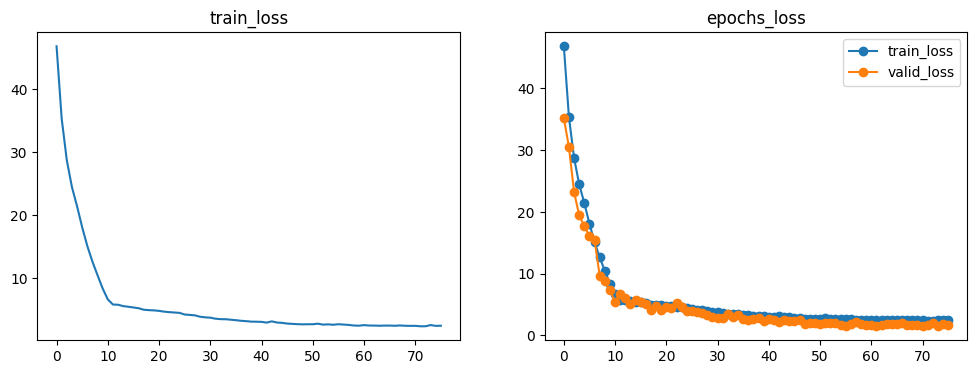

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(train_epochs_loss[:])
plt.title("train_loss")
plt.subplot(122)
plt.plot(train_epochs_loss, '-o', label="train_loss")
plt.plot(valid_epochs_loss, '-o', label="valid_loss")
plt.title("epochs_loss")
plt.legend()
plt.show()

# Tester

In [10]:
def tester(final=True):
    print("***********- ***********- Init -*************")
    args = Args()

    print("***********- ***********- Read data and processing -*************")
    print("Loading data...")
    train_data = pd.read_csv(args.data_path+args.train_file).values
    test_data = pd.read_csv(args.data_path+args.test_file).values
    train_data, valid_data = train_valid_split(train_data, args.split_ratio, args.rand_seed)

    print("Selecting features...")
    x_train, _, x_test, _, _ = select_feat(train_data, valid_data, test_data, select_all=False)

    test_dataset = COVID19Dataset(x_test)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=args.batch_size, shuffle=False, pin_memory=True, num_workers=args.WORKERS)

    print("***********- ***********- Loading model -*************")
    if(len(args.gpus) == 0):
        model = My_Model(input_dim=x_train.shape[1])
        print("***********- ***********- Using CPU -*************")
    elif(len(args.gpus) == 1):
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        print("***********- ***********- Using Single GPU -*************")
    else:
        gpus = ','.join(str(i) for i in args.gpus)
        os.environ["CUDA_VISIBLE_DEVICES"] = gpus
        model = My_Model(input_dim=x_train.shape[1]).cuda()
        gpus = [i for i in range(len(args.gpus))]
        model = torch.nn.DataParallel(model, device_ids=gpus)
        print("***********- ***********- Using Multi GPU -*************")
    
    model_best_path=args.MODEL_PATH+'/{}_best_params.pth'.format(args.model_name)
    model_final_path=args.MODEL_PATH+'/{}_final_params.pth'.format(args.model_name)
    
    if final:
        model.load_state_dict(torch.load(model_final_path))
        print("***********- ***********- Using Final Model -*************")
    else:
        model.load_state_dict(torch.load(model_best_path))
        print("***********- ***********- Using Best Model -*************")

    print("***********- ***********- Test begin -*************")
    preds = []
    model.eval()
    # =========================test=======================
    for idx, (X) in enumerate(tqdm(test_dataloader)):
        if (len(args.gpus) > 0):
            X = X.cuda()
        with torch.no_grad():
            outputs = model(X)
            preds.append(outputs.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()

    print("***********- ***********- Save predictions -*************")
    save_file = args.submit_file
    with open(save_file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

    print("***********- ***********- Test finished -*************")

# Testing

In [11]:
tester(final=True)

***********- ***********- Init -*************
***********- ***********- Read data and processing -*************
Loading data...
Selecting features...
***********- ***********- Loading model -*************
***********- ***********- Using Single GPU -*************
***********- ***********- Using Final Model -*************
***********- ***********- Test begin -*************


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 23.57it/s]

***********- ***********- Save predictions -*************
***********- ***********- Test finished -*************
